In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam, Adadelta
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import numpy as np
%matplotlib inline

# Ноутбук для ДЗ №4 обработка временных последовательностей RNN
В данном дз вам будут данных времменая последовательно, которая описывает распределение хитов по времени за несколько лет. Вам нужно будет обучить модель RNN на исторических данных и потом сделать предсказание для "будущего" года, в текущей задаче это 2019 год

## Готовим данные
Три файла с данными
1. исторические данные - train
2. Тестовые данные текущего момента - derived
3. Пример сабмита резкльтатов конкурса на кагле

In [3]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [4]:
data = pd.read_csv('rnnworkshowvkautumn2022/train.csv')
data

,date,hits
0,2016-01-01,201979088
1,2016-01-02,223095158
2,2016-01-03,233791442
3,2016-01-04,259684220
4,2016-01-05,267112490
...,...,...
1091,2018-12-27,241134980
1092,2018-12-28,234865040
1093,2018-12-29,195884690
1094,2018-12-30,125587958


In [5]:
data_train = read_set('rnnworkshowvkautumn2022/train.csv')
data_test =  read_set('rnnworkshowvkautumn2022/derived.csv')
data_sample = read_set('rnnworkshowvkautumn2022/sample_submission.csv')

In [6]:
data_train

,value
date,
2016-01-01,201979088
2016-01-02,223095158
2016-01-03,233791442
2016-01-04,259684220
2016-01-05,267112490
...,...
2018-12-27,241134980
2018-12-28,234865040
2018-12-29,195884690


In [7]:
data_test

,value
date,
2019-01-01,108624560
2019-01-02,130814504
2019-01-03,147999398
2019-01-04,148669766
2019-01-05,131564540
...,...
2019-12-27,248681252
2019-12-28,139485986
2019-12-29,122282606


### Проверим наши данные, что мы загрузили

In [8]:
print( data_train.info() )
print( data_test.info() )
print( data_sample.info() )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   1096 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None


In [9]:
data_train.describe()

,value
count,1.096000e+03
mean,2.792255e+08
std,7.677884e+07
min,1.103556e+08
25%,2.317301e+08
50%,2.791131e+08
75%,3.287730e+08
max,4.550733e+08


In [10]:
data_test.describe()

,value
count,3.650000e+02
mean,2.250691e+08
std,6.798229e+07
min,1.055197e+08
25%,1.467913e+08
50%,2.525773e+08
75%,2.724223e+08
max,3.410300e+08


In [11]:
data_train

,value
date,
2016-01-01,201979088
2016-01-02,223095158
2016-01-03,233791442
2016-01-04,259684220
2016-01-05,267112490
...,...
2018-12-27,241134980
2018-12-28,234865040
2018-12-29,195884690


In [12]:
data_sample.describe()

,value
count,365.0
mean,110355560.0
std,0.0
min,110355560.0
25%,110355560.0
50%,110355560.0
75%,110355560.0
max,110355560.0


## Графики наших временных последовательностей

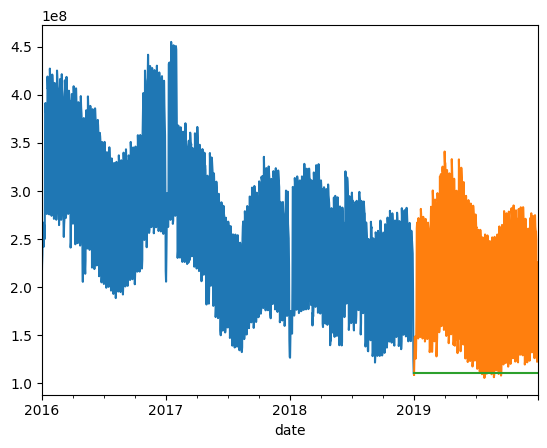

In [13]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
data_sample['value'].plot(kind = 'line')
plt.show()

## Статистическая модель [ARIMA](https://ru.wikipedia.org/wiki/ARIMA)


In [14]:
# обучаем модель
arima_model=model = pm.auto_arima(data_train, seasonal = True,m = 4,test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=42026.193, Time=2.72 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=42912.228, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=42352.663, Time=0.84 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=42271.764, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=45821.113, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=42138.118, Time=1.17 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=42130.455, Time=2.53 sec
 ARIMA(2,0,2)(2,0,1)[4] intercept   : AIC=41842.461, Time=5.58 sec
 ARIMA(2,0,2)(2,0,0)[4] intercept   : AIC=42088.126, Time=3.21 sec
 ARIMA(2,0,2)(2,0,2)[4] intercept   : AIC=41829.133, Time=5.93 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=42095.534, Time=6.51 sec
 ARIMA(1,0,2)(2,0,2)[4] intercept   : AIC=42117.810, Time=9.11 sec
 ARIMA(2,0,1)(2,0,2)[4] intercept   : AIC=42107.831, Time=4.37 sec
 ARIMA(3,0,2)(2,0,2)[4] intercept   : AIC=41841.297, Time=8.07 sec
 ARIMA(2,0,3)(2,0,2

In [15]:
prediction = pd.DataFrame(model.predict(n_periods = int(data_test.size)), data_test.index)

In [16]:
prediction

,0
date,
2019-01-01,2.365693e+08
2019-01-02,2.924234e+08
2019-01-03,2.378438e+08
2019-01-04,1.590419e+08
2019-01-05,2.126749e+08
...,...
2019-12-27,2.784914e+08
2019-12-28,2.730077e+08
2019-12-29,2.703278e+08


In [17]:
prediction = prediction.rename(columns = {0:'value'})

смотрим, что она нам предсказала

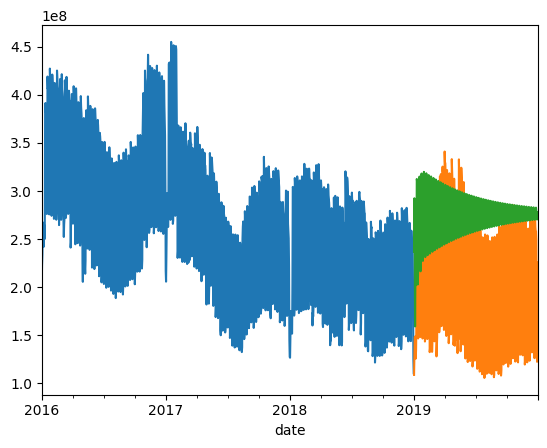

In [18]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
# plt.plot(data_forecaste, label = "Prediction")
prediction['value'].plot(kind = 'line')
plt.show()

### Функция подсчета метрик для конкурса

In [19]:
def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape  = np.average(mape) * 100
    return mape

### MAPE для ARIMA и тестового сабмишена

In [20]:
MAPE(data_test, prediction)

38.57035121292112

In [21]:
MAPE(data_test, data_sample)

44.81735178659308

## Из пандас строим датасет

In [22]:
class Stats:
    def __init__(self, dataset):
        self.mean = np.mean(dataset)
        self.std = np.std(dataset)
        self.data = (dataset - self.mean) / self.std 

stats = Stats(data_train)

/home/sklaa00/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [23]:
class TSDataset(Dataset):
    
    def __init__(self, data, seq_len):
        super().__init__()
        self._len = len(data) - seq_len + 1 
        self.mean = stats.mean
        self.std = stats.std
        self.data = (data - self.mean) / self.std 
        self.seq_len = seq_len
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        d = self.data[idx:idx + self.seq_len]
        targets = []
        days   = []
        months = []
        year = []
        for row in  d.iterrows():
            targets += [ row[1]['value'] ]
            days += [ row[0].day ]
            months += [row[0].month]
            year += [row[0].year]
            
        return torch.LongTensor(days), \
               torch.LongTensor(months), \
               torch.LongTensor(year), \
               torch.FloatTensor(targets)

In [24]:
ds_train = TSDataset(data_train, 20) 
ds_test  = TSDataset(data_test, 20)
print(len(ds_train))


1077


## Теперь нужно определить нашу модель 

In [25]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(777)

In [26]:
class TimeSeriesModel(nn.Module):
        def __init__(self, hidden_size: int, input_sizes: tuple):            
            super().__init__()
            self.mon_emb = nn.Embedding(12+1, input_sizes[0])
            self.day_emb = nn.Embedding(31+1, input_sizes[1])

            self._rnn = nn.LSTM(input_sizes[0] + input_sizes[1]+1,  hidden_size,  batch_first=True)
            self._output = nn.Linear(hidden_size, 1)

        def forward(self, batch, ctx = None):
            days, mons, _, targets = batch
            mon_tensor = self.mon_emb(mons)
            day_tensor = self.day_emb(days)
            rnn_input  = torch.cat([mon_tensor, day_tensor], dim=-1)
            targets = targets.unsqueeze(-1)
            rnn_input = torch.cat([rnn_input, targets ], dim=-1)
            rnn_input = rnn_input[:, :-1, :] if ctx is None else rnn_input
            output, ctx = self._rnn(rnn_input, ctx)
            output = self._output(output).squeeze()
            return output, ctx        

### Определяем даталоадеры для теста и трейна

In [27]:
dl_train = DataLoader(ds_train, 8 , True)
dl_test = DataLoader(ds_test, 8 , False)

In [28]:
series_model = TimeSeriesModel(32, (4,4))

In [29]:
series_model

TimeSeriesModel(
  (mon_emb): Embedding(13, 4)
  (day_emb): Embedding(32, 4)
  (_rnn): LSTM(9, 32, batch_first=True)
  (_output): Linear(in_features=32, out_features=1, bias=True)
)

In [30]:
loss = nn.L1Loss()
optimizer = Adam(series_model.parameters(), lr=5e-4)

In [31]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [32]:
# инициализируем тензорборд, для вывода графиков
writer = SummaryWriter(log_dir='./tensor_board')

### Обучаем модель

In [33]:
global_epoch = 0
global_iter = 0

In [34]:
def test_model(epoch):
    test_iter  = tqdm(dl_test)
    sum_loss = 0
    num_batches = 0
    for i, batch in enumerate(test_iter):
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        target = batch[-1][:, 1:]
        result, _ = series_model(batch)
        batch_loss = loss(result, target)
        sum_loss += batch_loss
        num_batches += 1
    sum_loss /= num_batches
    writer.add_scalar('Loss/val', sum_loss , epoch)
    return sum_loss

In [35]:
# модель обучаем в режиме teacher forcing, т.е. на вход подаем сразу всю последовательность,
# на выходе таргет должен быть смещен на один временной шаг, чтобы правильно считался лосс

for epoch in np.arange(0, 20):
    epoch_iter = tqdm(dl_train)
    series_model.train()
    for batch in epoch_iter:
        optimizer.zero_grad()
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        target = batch[-1][:,1:]
        result, _ = series_model(batch)        
        batch_loss = loss(result, target)
        batch_loss.backward()
        epoch_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, batch_loss))
        optimizer.step()
        writer.add_scalar('Loss/train', batch_loss , global_iter)
        global_iter += 1
    with torch.no_grad():
        series_model.eval()
        test_model(global_epoch)
    global_epoch += 1

100%|██████████| 44/44 [00:00<00:00, 49.34it/s]


In [36]:
# сохраняем модель
torch.save(series_model.state_dict(), 'models/series_model_15.ptx')

### Восстанавливаем модель

In [55]:
series_model = TimeSeriesModel(32, (4,4))
series_model.load_state_dict(torch.load('models/series_model_15.ptx'))

series_model

TimeSeriesModel(
  (mon_emb): Embedding(13, 4)
  (day_emb): Embedding(32, 4)
  (_rnn): LSTM(9, 32, batch_first=True)
  (_output): Linear(in_features=32, out_features=1, bias=True)
)

### TODO
Теперь нам нужно для нашего тестового сета сгенерировать результат, и сделать правильный сабмишен. В отличии от режима обучения мы не должгны использовать значения таргетов в тесте, поэтому нам придется тут реализовывать инкрементальный режим генерации сети, т.е. когда на вход подаются фичи и таргет с предыдущего шага на каждоим шаге генерации.

In [56]:
train_last_window = DataLoader(ds_train, 1, False)
last_window = None
cnt = 0
for b in train_last_window:
    cnt += 1
    last_window = b
print(cnt)

1077


In [57]:
last_window

[tensor([[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
          30, 31]]),
 tensor([[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
          12, 12]]),
 tensor([[2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
          2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018]]),
 tensor([[-0.1291, -0.1936, -0.4293, -1.7672, -1.7341, -0.2415, -0.3038, -0.1620,
          -0.2428, -0.5024, -1.7640, -1.7625, -0.2683, -0.4030, -0.4092, -0.4963,
          -0.5780, -1.0860, -2.0020, -2.2004]])]

In [58]:
with open('result/submission.csv', 'wt') as fd:
    print('date,hits', file=fd)

    with torch.no_grad():
        series_model.eval()
        ds_val = TSDataset(data_test, 1)
        output, ctx = series_model(last_window)
        d, m, year, prev = last_window[0][0,-1:], last_window[1][0,-1:], last_window[2][0,-1:], output[-1:]
        # print(d, m, year)
        result = []
        
        for i in np.arange(len(ds_val)):
            output, ctx = series_model((d.unsqueeze(0), m.unsqueeze(0), 0, prev.unsqueeze(0)), ctx)
            result += [float(output)]
            out_val = ds_val[i]
            d, m, year, prev = out_val[0], out_val[1], out_val[2], torch.FloatTensor([output])
            print("%d-%02d-%02d,%d" %(year, m, d, float(prev) * stats.std + stats.mean), file=fd)

In [59]:
data_nn_submission = read_set('result/submission.csv')
print(len(data_nn_submission))
MAPE(data_test, data_nn_submission)

365


33.81183608722309

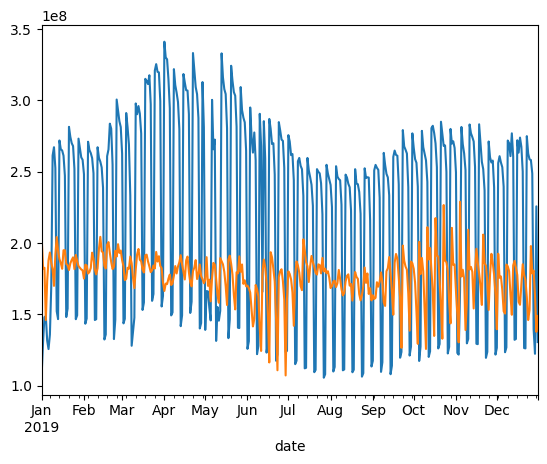

In [60]:
plt.figure()
# data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
#plt.plot(data_forecaste, label = "Prediction")
data_nn_submission['value'].plot(kind = 'line')
plt.show()